In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import butter, sosfilt, stft, welch
from scipy.optimize import curve_fit

In [2]:
def get_psd(data, channel=1):
    fs = int(np.ceil(1 / (data[0, 1] - data[0, 0])))
    nperseg = fs / 10
    
    ff, pp = welch(data[channel], fs=fs, nperseg=nperseg)
    return ff, pp

def peak_amplitude_stft(tod, fs, nperseg, driving_freq):
    
    ff, tt, Zxx = stft(tod, fs=fs, nperseg=nperseg)
    sig = np.abs(Zxx)
    f = np.where(ff==driving_freq)[0][0]

    # time, peak amplitude^2, sample frequency, sftp
    return tt, sig[f], ff, Zxx[f]

In [3]:
def get_filtered_signal(data, f_hp, f_lp, order=8):
    fs = int(np.ceil(1 / (data[0, 1] - data[0, 0]))) * 1000 # Sampling rate in Hz
    
    sos_hp = butter(order, f_hp, 'hp', fs=fs, output='sos')
    sos_lp = butter(order, f_lp, 'lp', fs=fs, output='sos')
    
    filtered = sosfilt(sos_hp, data[1])
    filtered_filtered = sosfilt(sos_lp, filtered)
    
    return filtered_filtered

In [4]:
def plot_peak_amp(data, drive_freq):
    fs = int(np.ceil(1 / (data[0, 1] - data[0, 0])))
    nperseg = fs / 10

    tt, sig, ff, Zxx = peak_amplitude_stft(data[1], fs, nperseg, drive_freq)
    
    fig, ax = plt.subplots(figsize = (20, 6))
    ax.grid()
    ax.plot(tt, sig, '-')

    ax.set_xlabel('Time (s)', fontsize=18)
    ax.set_ylabel(f'Peak amplitude@{int(drive_freq/1000)} kHz (V)', fontsize=18)
    ax.set_title('1 mbar, driving field = 20 V peak to peak', fontsize=20)
    
    return fig, ax

## Determine the charge state of the nanosphere

In [98]:
data_file = r"D:\Experiment\Charging\20230909\charging_50s_42khz_5.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

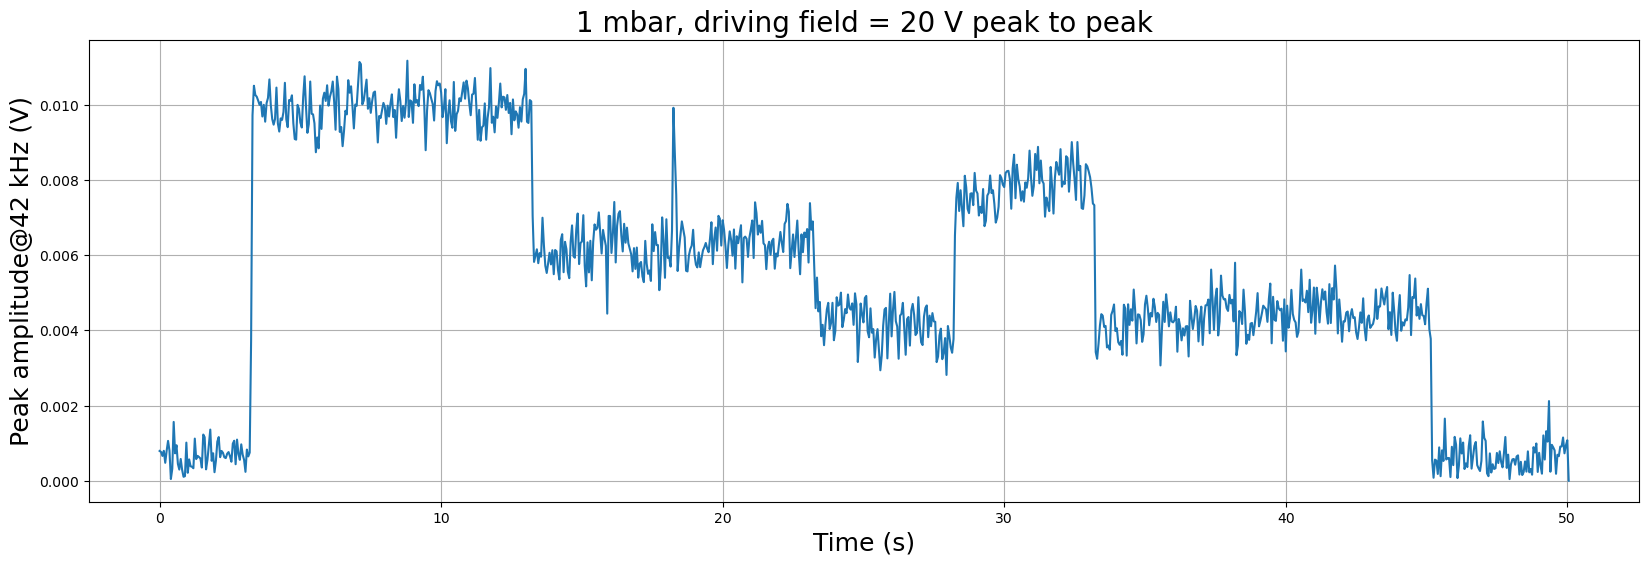

In [99]:
fig, ax = plot_peak_amp(data, 42000)

Looks like there are two charges on the sphere.

## Apply driving field to calibrate charge/mass

First fit the z peak to get the center frequency and damping. The PSD is averaged over 20 seconds.

In [152]:
def peak_func(x, amp, omega_0, gamma):
    """A Lorentzian line shape"""
    return amp * gamma / ( ( omega_0**2 - x**2)**2 + gamma**2 * x**2 )

def fit_peak(x, y, peak_func, p0=None):
    popt, pcov = curve_fit(peak_func, x, y, p0=p0)
    
    # Return central frequency and gamma
    return popt, x, peak_func(x, *popt)

In [153]:
data_file = r"D:\Experiment\Charging\20230909\noefield_20s.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

ff, pp = get_psd(data)

Amplitude: 247488652.54183978, central frequency: 40318.575622096534 Hz, gamma: 4579.596511053749


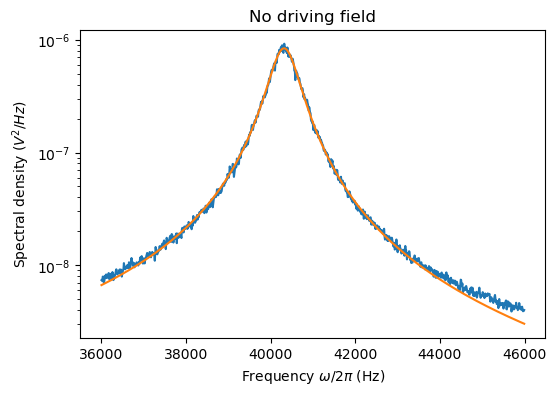

In [154]:
lb, ub = 3600, 4600

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ff[lb:ub], pp[lb:ub])

# Fit with a Lorentzian and plot
popt, omega_fit, p_fit = fit_peak(ff[lb:ub]*2*np.pi, pp[lb:ub], peak_func, p0=[1e8, 41500*2*np.pi, 45000])
ax.plot(omega_fit/(2*np.pi), p_fit)

amp, omega0, gamma = popt[0], popt[1], popt[2]
print(f'Amplitude: {amp}, central frequency: {omega0/(2*np.pi)} Hz, gamma: {gamma}')

ax.set_title('No driving field')
ax.set_xlabel('Frequency $\omega / 2 \pi$ (Hz)')
ax.set_ylabel('Spectral density ($V^2 / Hz$)')

ax.set_yscale('log')

Integrate over the Lorentzian peak using the analytical formula

In [155]:
T   = 300  # K
kb  = 1.38e-23
rho = 2200 # kg/m^3
r   = 167e-9 / 2
m   = rho * (4 * np.pi / 3) * r**3 

# Again need to take care of 2 pi normalization
# because the formula assume integrating over `omega`, not `f`
v2 = 0.5 * np.pi/(gamma * omega0**2) * amp * gamma / (2 * np.pi)

# Calibration factor converting <V^2> to (x^2)
c_cal_square = (v2 * m * omega0**2) / (kb * T)
print(fr'Calibration factor square $c^2$: {c_cal_square}')

Calibration factor square $c^2$: 80179930463.28465


Next we calculate the area below the driving peak

In [104]:
data_file = r"D:\Experiment\Charging\20230909\nohv_20s_42khz_5.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

ff, pp = get_psd(data)

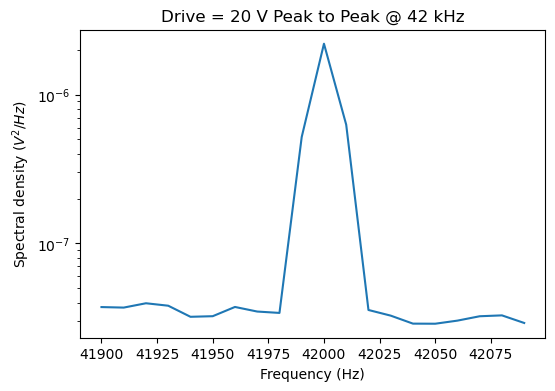

In [105]:
lb, ub = 4190, 4210
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ff[lb:ub], pp[lb:ub])

ax.set_title('Drive = 20 V Peak to Peak @ 42 kHz')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Spectral density ($V^2 / Hz$)')

ax.set_yscale('log')

Just do simple numerical integration for now...

In [106]:
all_idx = np.arange(lb, ub, 1)
excluding_peak = np.logical_or(all_idx < 4197, all_idx > 4203)

area_all = np.trapz(pp[all_idx], ff[all_idx]*2*np.pi)
area_excluding_peak = np.trapz( pp[all_idx[excluding_peak]], ff[all_idx[excluding_peak]]*2*np.pi )

# Excluding background contribution (which is very small anyway)
# Take care of 2 pi normalization after numerical integration
# because we integrated over omega here
v2_drive = (area_all - area_excluding_peak) / (2 * np.pi)

Convet $\langle V^2_\text{drive} \rangle$ to $\langle z^2_\text{drive} \rangle$ using the calibration factor obtained above, and use that to derive the amplitude of the force.

Assume the E field at the center of the trap is 250*10 V/m, we can derive the charge from the force ampltiude

In [107]:
omega_drive = 42000 * 2 * np.pi

x2_drive = v2_drive / c_cal_square
f_amp_squared = x2_drive * 2 * m**2 * ( (omega0**2 - omega_drive**2)**2 + gamma**2 * omega_drive**2)

charge = np.sqrt(f_amp_squared) / (1.6e-19 * 250*10)
print(f'Charge on the sphere derived through a driving E field: +/- {charge:.2f} e')

Charge on the sphere derived through a driving E field: +/- 2.14 e


It is fine if this does not agree perfectly - at about 1 mbar there is usually mathonol attached to the particle so the mass and also expected response is not accurate here. Support evidence is usually the particle change freuqencies when pumped down to about $10^{-2}$ mbar.

## Particle at low pressure

In [108]:
data_file = r"D:\Experiment\Low Pressure\20230909\about1e-6mbar.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

ff, pp = get_psd(data)

Low Pressure - Amplitude: 751098.5982029458, central frequency: 39674.509911680536 Hz, gamma: 522.791835386927


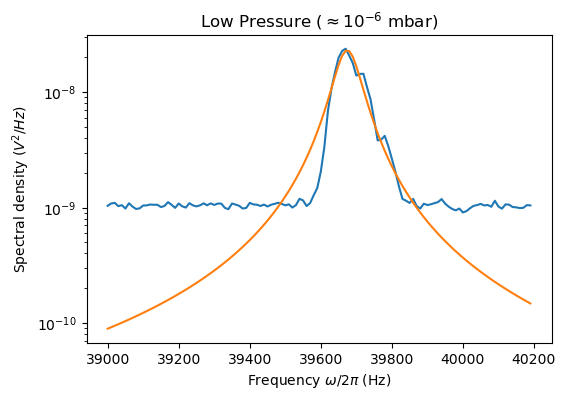

In [119]:
lb, ub = 3900, 4020

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ff[lb:ub], pp[lb:ub])

# Fit with a Lorentzian and plot
popt, omega_fit, p_fit = fit_peak(ff[lb:ub]*2*np.pi, pp[lb:ub], peak_func, p0=[535, 39500*2*np.pi, 500])
ax.plot(omega_fit/(2*np.pi), p_fit)

amp_low, omega0_low, gamma_low = popt[0], popt[1], popt[2]
print(f'Low Pressure - Amplitude: {amp_low}, central frequency: {omega0_low/(2*np.pi)} Hz, gamma: {gamma_low}')

ax.set_title(r'Low Pressure ($\approx 10^{-6}$ mbar)')
ax.set_xlabel('Frequency $\omega / 2 \pi$ (Hz)')
ax.set_ylabel('Spectral density ($V^2 / Hz$)')

ax.set_yscale('log')

In [124]:
# Calculate effective temperature
# Assume 1 mbar is 300 K
v2_low = 0.5 * np.pi/(gamma_low * omega0_low**2) * amp_low * gamma_low / (2 * np.pi)
print(f'The effective temperature is {(v2_low / v2) * 300 * (omega0_low / omega0)**2} K')

The effective temperature is 0.9104642865304302 K
